In [1]:
import os
import time

import umap
import anndata
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from batch_entropy_mixing import batch_entropy_mixing_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
from scnym.api import scnym_api

In [3]:
data_file   = "Downloads/pbmc_rare_0.003619.h5ad"
adata = sc.read_h5ad(data_file)
adata.obs['cell_type']=adata.obs['final_annotation']
adata.obs['source']='reference'
adata.obs['source'][adata.obs['study']!='Oetjen']='target'
source = adata[adata.obs['study']=='Oetjen']
target = adata[adata.obs['study']!='Oetjen']

In [8]:
data = pd.read_csv("D:/GEO/SMILE/H5AD/human_pancreas_data.csv",header=0,index_col=0)
data = data.T
y = pd.read_csv("D:/GEO/SMILE/H5AD/human_pancreas_data_label.csv",header=0,index_col=0)
y.index = data.index
adata = anndata.AnnData(X=data,obs=y)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata = adata[adata.obs['celltype']!='mast']
adata = adata[adata.obs['celltype']!='macrophage']
adata = adata[adata.obs['celltype']!='epsilon']
adata = adata[adata.obs['celltype']!='schwann']

adata.obs['celltype'][adata.obs['celltype']=='acinar']='Pancreas Acinar'
adata.obs['celltype'][adata.obs['celltype']=='alpha']='Pancreas Alpha'
adata.obs['celltype'][adata.obs['celltype']=='beta']='Pancreas Beta'
adata.obs['celltype'][adata.obs['celltype']=='delta']='Pancreas Delta'
adata.obs['celltype'][adata.obs['celltype']=='ductal']='Pancreas Ductal'
adata.obs['celltype'][adata.obs['celltype']=='endothelial']='Pancreas Endothelial'
adata.obs['celltype'][adata.obs['celltype']=='gamma']='Pancreas Gamma'
adata.obs['celltype'][adata.obs['celltype']=='activated_stellate']='Pancreas Stellate'
adata.obs['celltype'][adata.obs['celltype']=='quiescent_stellate']='Pancreas Stellate'

adata.obs['tech'][adata.obs['tech']=='celseq']='Pancreas CelSeq'
adata.obs['tech'][adata.obs['tech']=='celseq2']='Pancreas CelSeq2'
adata.obs['tech'][adata.obs['tech']=='fluidigmc1']='Pancreas Fluidigm C1'
adata.obs['tech'][adata.obs['tech']=='indrop']='Pancreas inDrop'
adata.obs['tech'][adata.obs['tech']=='smartseq2']='Pancreas SS2'

adata.obs['cell_type']=adata.obs['celltype']
adata.obs['study']=adata.obs['tech']
adata.obs['source']='reference'
adata.obs['source'][adata.obs['study']!='Pancreas inDrop']='target'
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=3000, subset=True,batch_key='study')
source = adata[adata.obs['study']=='Pancreas inDrop']
target = adata[adata.obs['study']!='Pancreas inDrop']
sc.pp.filter_genes(source, min_cells=3)

Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
... storing 'tech' as categorical
... storing 'replicate' as categorical
... storing 'assigned_cluster' as categorical
... storing 'celltype' as categorical
... storing 'dataset' as categorical
... storing 'cell_type' as categorical
... storing 'study' as categorical
... storing 'source' as categorical
Trying to set attribute `.var` of view, copying.


In [9]:
source.obs['final_annotation'] = source.obs['cell_type']
target.obs['final_annotation']="Unlabeled"
adata = source.concatenate(target)

Trying to set attribute `.obs` of view, copying.


In [3]:
data_file   = "Downloads/mouse_brain_regions.h5ad"
adata = sc.read_h5ad(data_file)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=3000, subset=True,batch_key='study')
adata.obs['final_annotation'] = adata.obs['cell_type']

In [4]:
source = adata[adata.obs['study']=='Rosenberg']
target = adata[adata.obs['study']!='Rosenberg']
target.obs['final_annotation']="Unlabeled"
adata = source.concatenate(target)

Trying to set attribute `.obs` of view, copying.


In [10]:
##run scNym
start_time = time.time()
scnym_api(
    adata=adata,
    task='train',
    groupby='final_annotation',
    out_path='./scnym_output',
    config='no_new_identity',
)
print("--- %s mins ---" % int((time.time() - start_time)/60))

CUDA compute device found.
6254 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (8446, 2732)
target   examples:  (6254, 2732)
X:  (8446, 2732)
y:  (8446,)
Not weighting classes and not balancing classes.
Found 2 unique domains.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Training complete.-----------------_______|

Evaluating model.
EVAL LOSS:  0.07523691467940807
EVAL ACC :  0.98698224852071
Predictions | Labels
[[0 

In [11]:
scnym_api(
    adata=adata,
    task='predict',
    key_added='scNym',
    trained_model='./scnym_output',
    out_path='./scnym_output',
    config='no_new_identity',
)

annotation = adata.obs['scNym'].values

##Fig2a
#print(round(adjusted_rand_score(adata[adata.obs['study']!='Rosenberg'].obs['cell_type'].values,
#                                np.array(annotation[adata.obs['study']!='Rosenberg'])),3))
#print(round(f1_score(adata[adata.obs['study']!='Rosenberg'].obs['cell_type'].values,
#                     np.array(annotation[adata.obs['study']!='Rosenberg']), average='macro'),3))
#print(round(accuracy_score(adata[adata.obs['study']!='Rosenberg'].obs['cell_type'].values,
#                           np.array(annotation[adata.obs['study']!='Rosenberg'])),3))

print(round(adjusted_rand_score(adata[adata.obs['source']!='reference'].obs['cell_type'],
                                np.array(annotation[adata.obs['source']!='reference'])),3))
print(round(f1_score(adata[adata.obs['source']!='reference'].obs['cell_type'],
                     np.array(annotation[adata.obs['source']!='reference']), average='macro'),3))
print(round(accuracy_score(adata[adata.obs['source']!='reference'].obs['cell_type'],
                           np.array(annotation[adata.obs['source']!='reference'])),3))

CUDA compute device found.
Loaded model predicting 8 classes from 2732 features
['Pancreas Acinar' 'Pancreas Alpha' 'Pancreas Beta' 'Pancreas Delta'
 'Pancreas Ductal' 'Pancreas Endothelial' 'Pancreas Gamma'
 'Pancreas Stellate']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|██████████| 15/15 [00:00<00:00, 40.72it/s]


Extracting model embeddings...
0.955
0.972
0.98


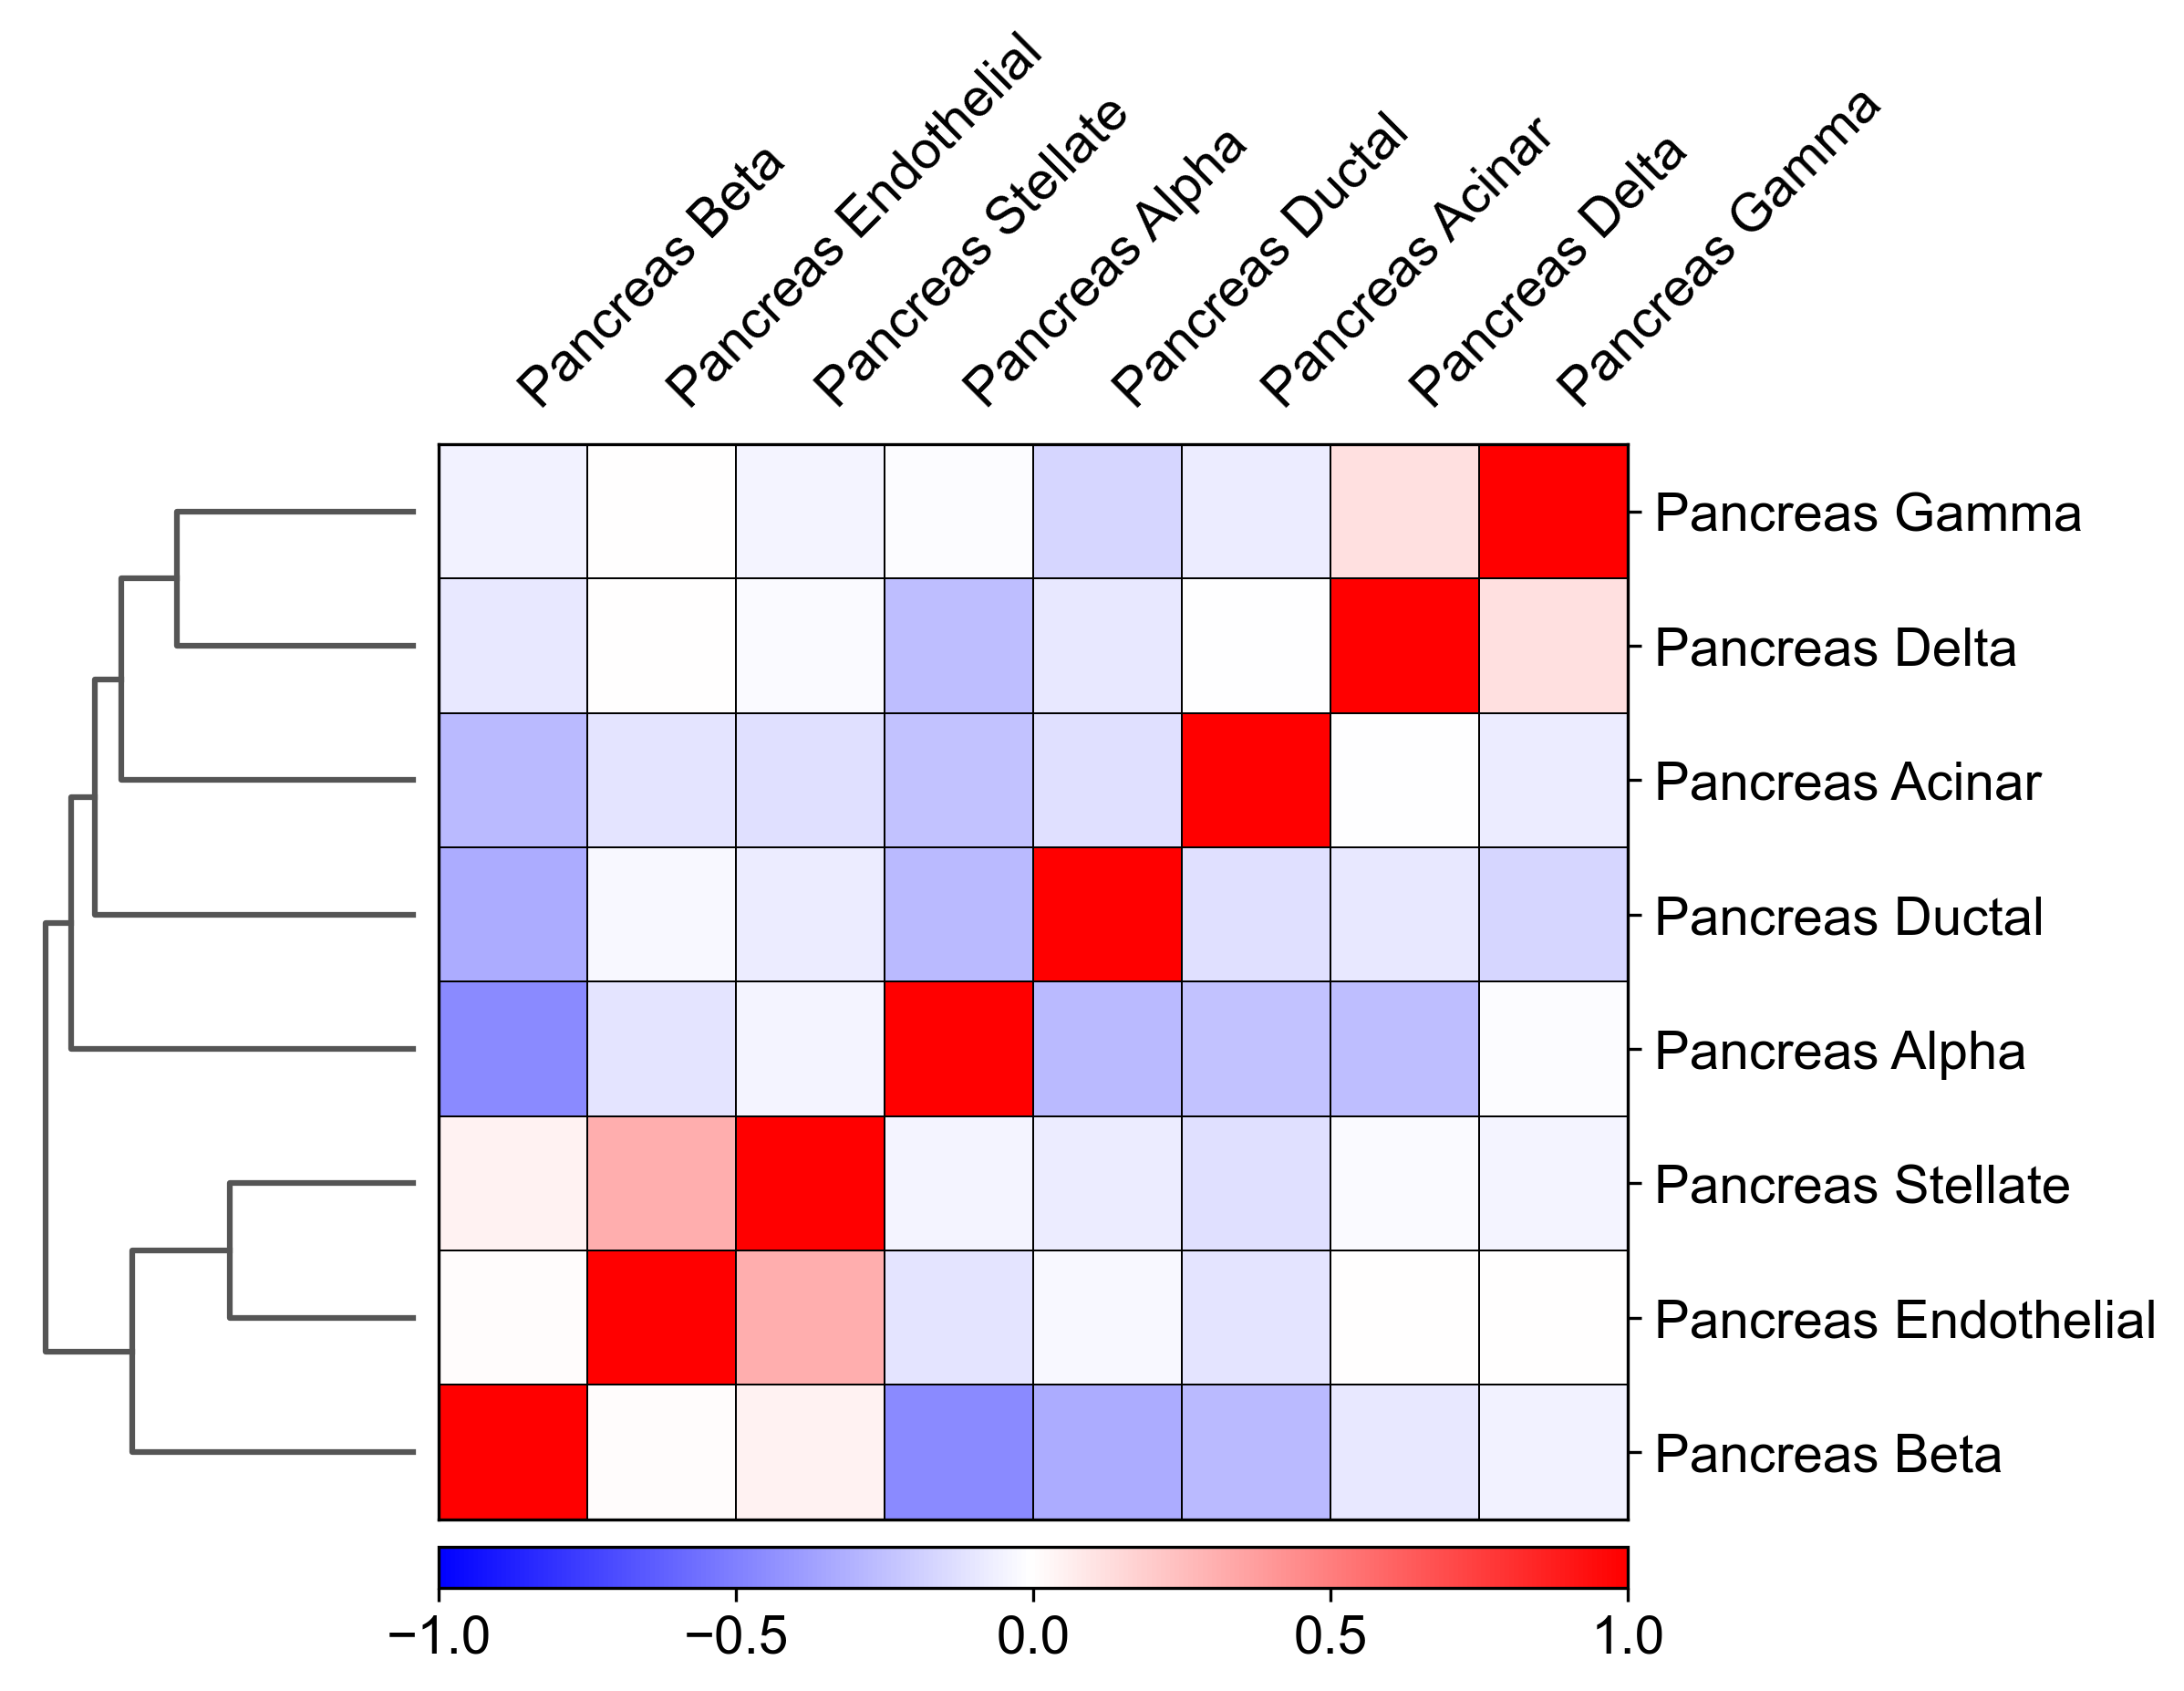

In [12]:
adata.obs['scNym']= pd.Series(adata.obs['cell_type'].values, dtype="category").values
#sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_score')
sc.tl.dendrogram(adata, 'scNym', use_rep='X_scnym',cor_method='spearman', linkage_method='ward')
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150)
sc.pl.correlation_matrix(adata, 'scNym', figsize=(7.5,5.5),save='pancreas_scNym_corr.svg')

... storing 'orig.ident' as categorical
... storing 'tech' as categorical
... storing 'replicate' as categorical
... storing 'assigned_cluster' as categorical
... storing 'dataset' as categorical
... storing 'study' as categorical
... storing 'source' as categorical
... storing 'final_annotation' as categorical
... storing 'scNym' as categorical


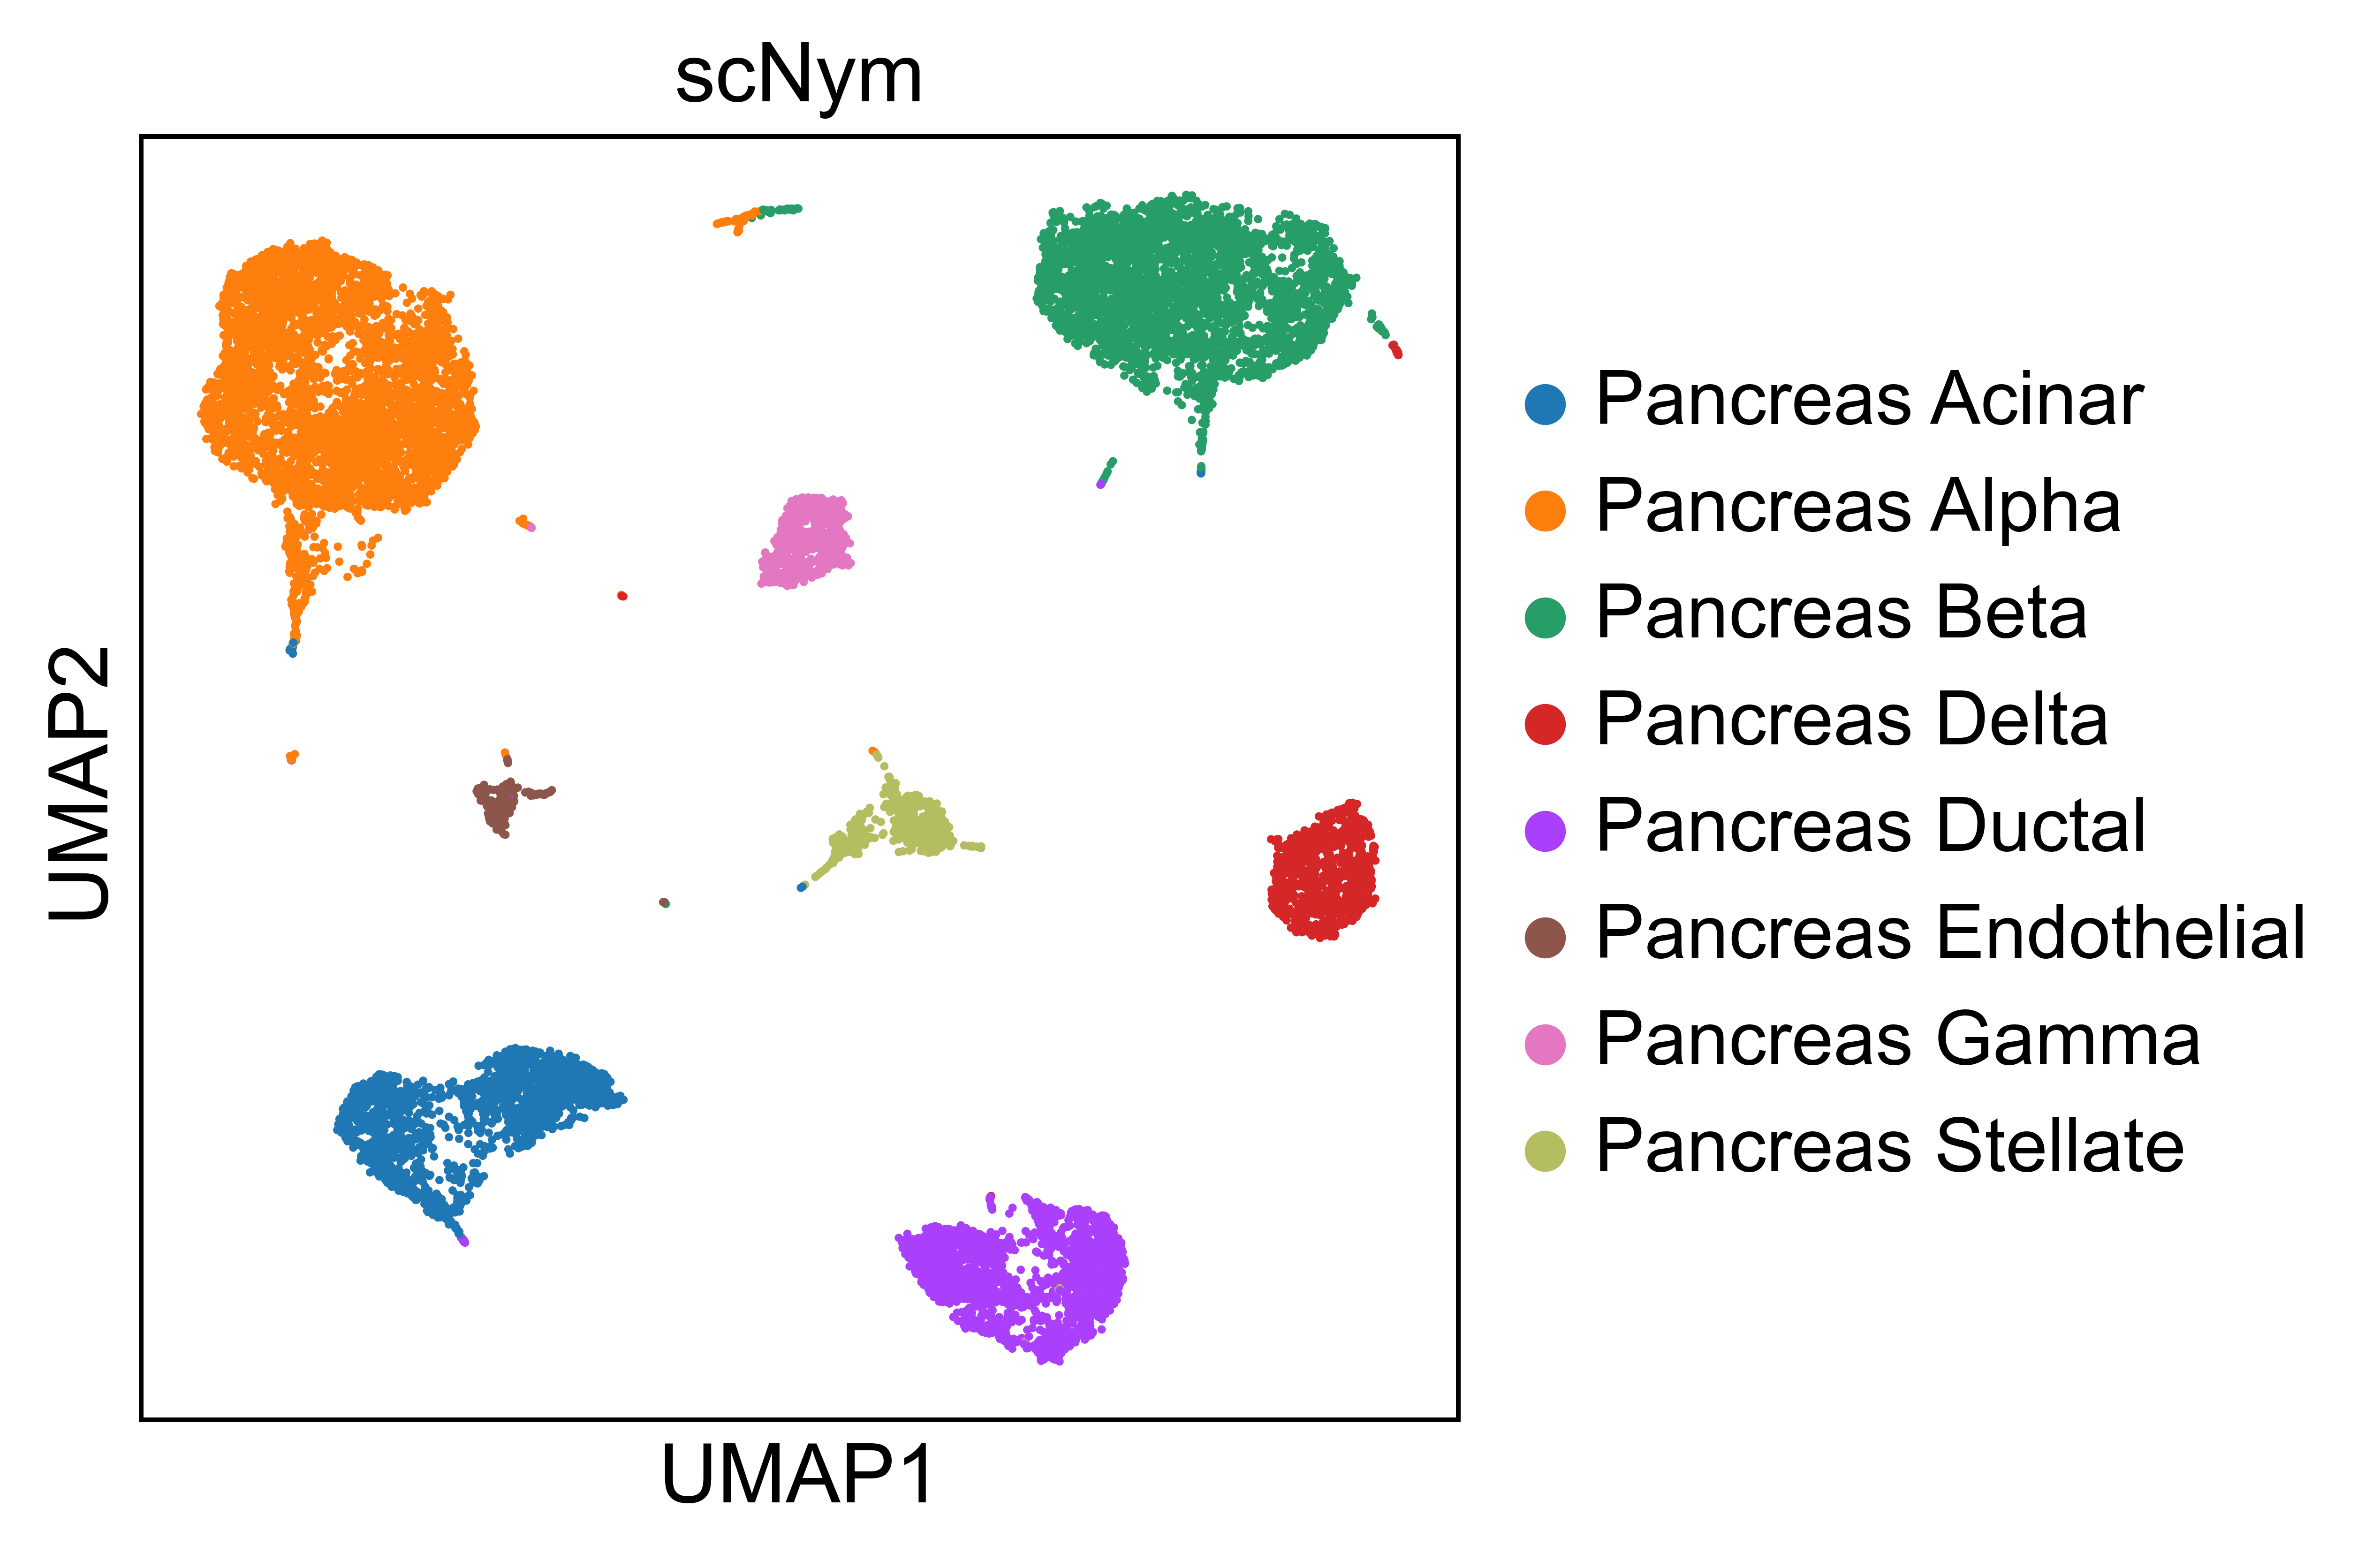

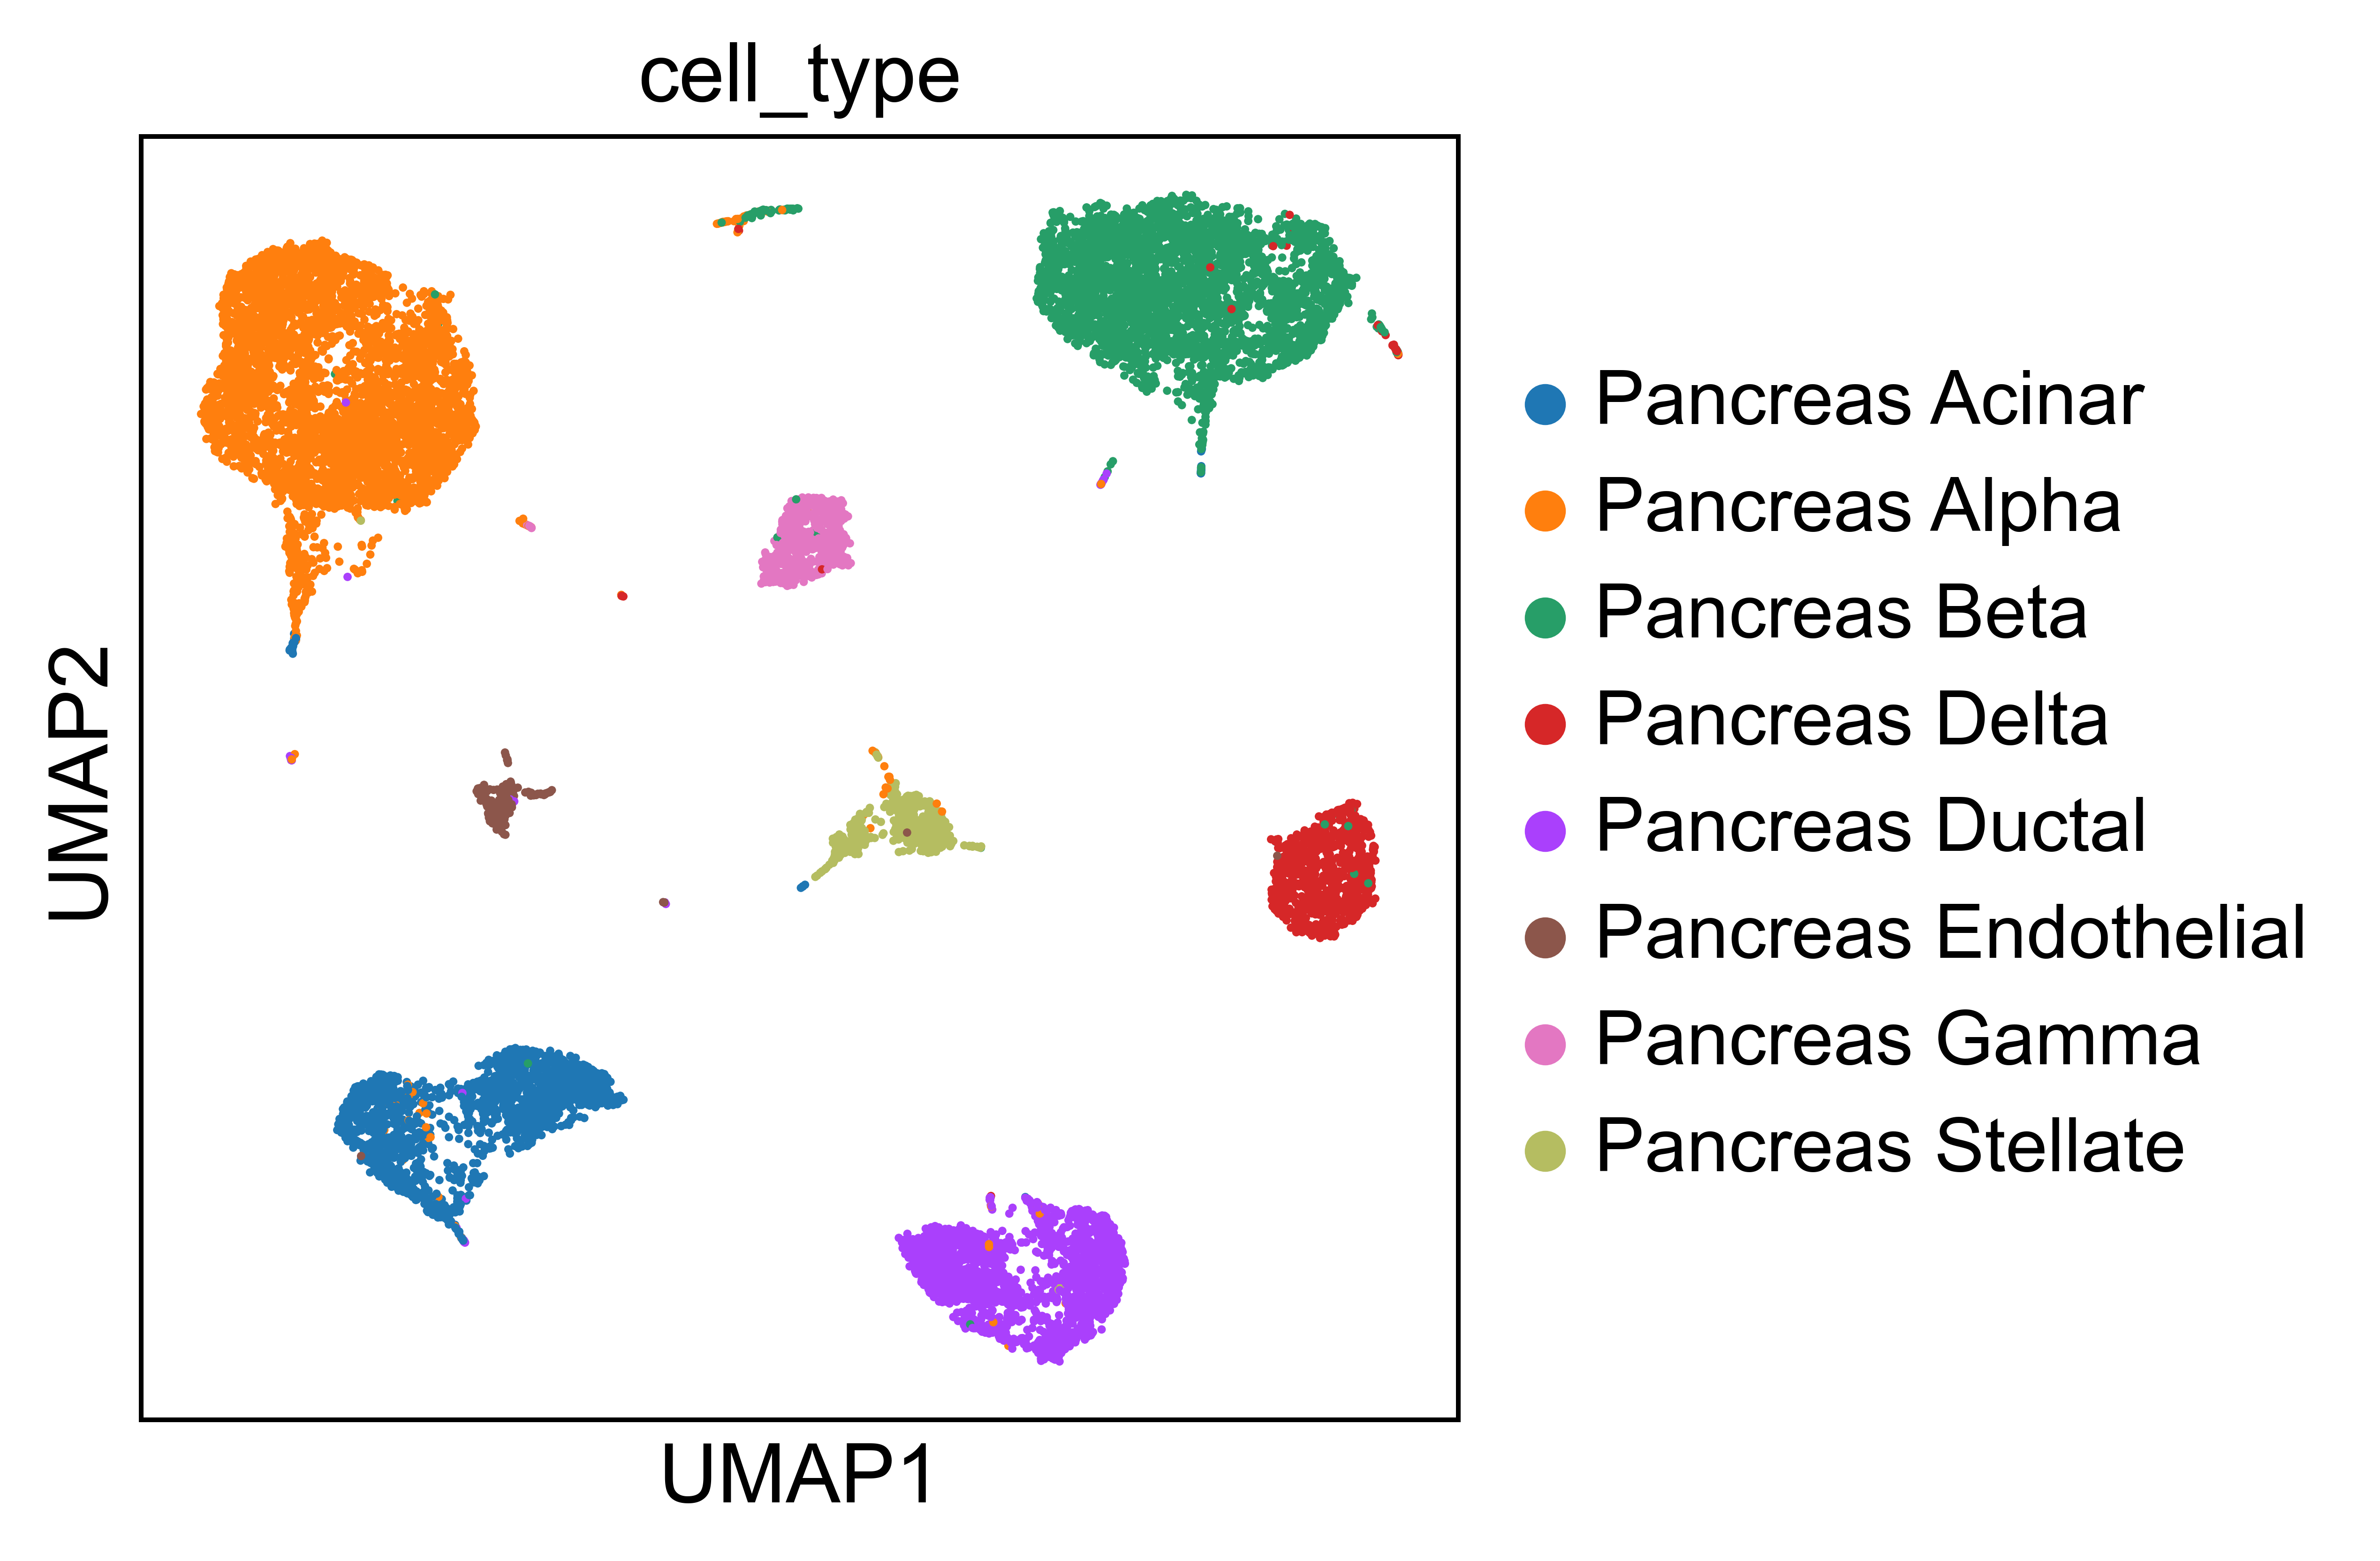

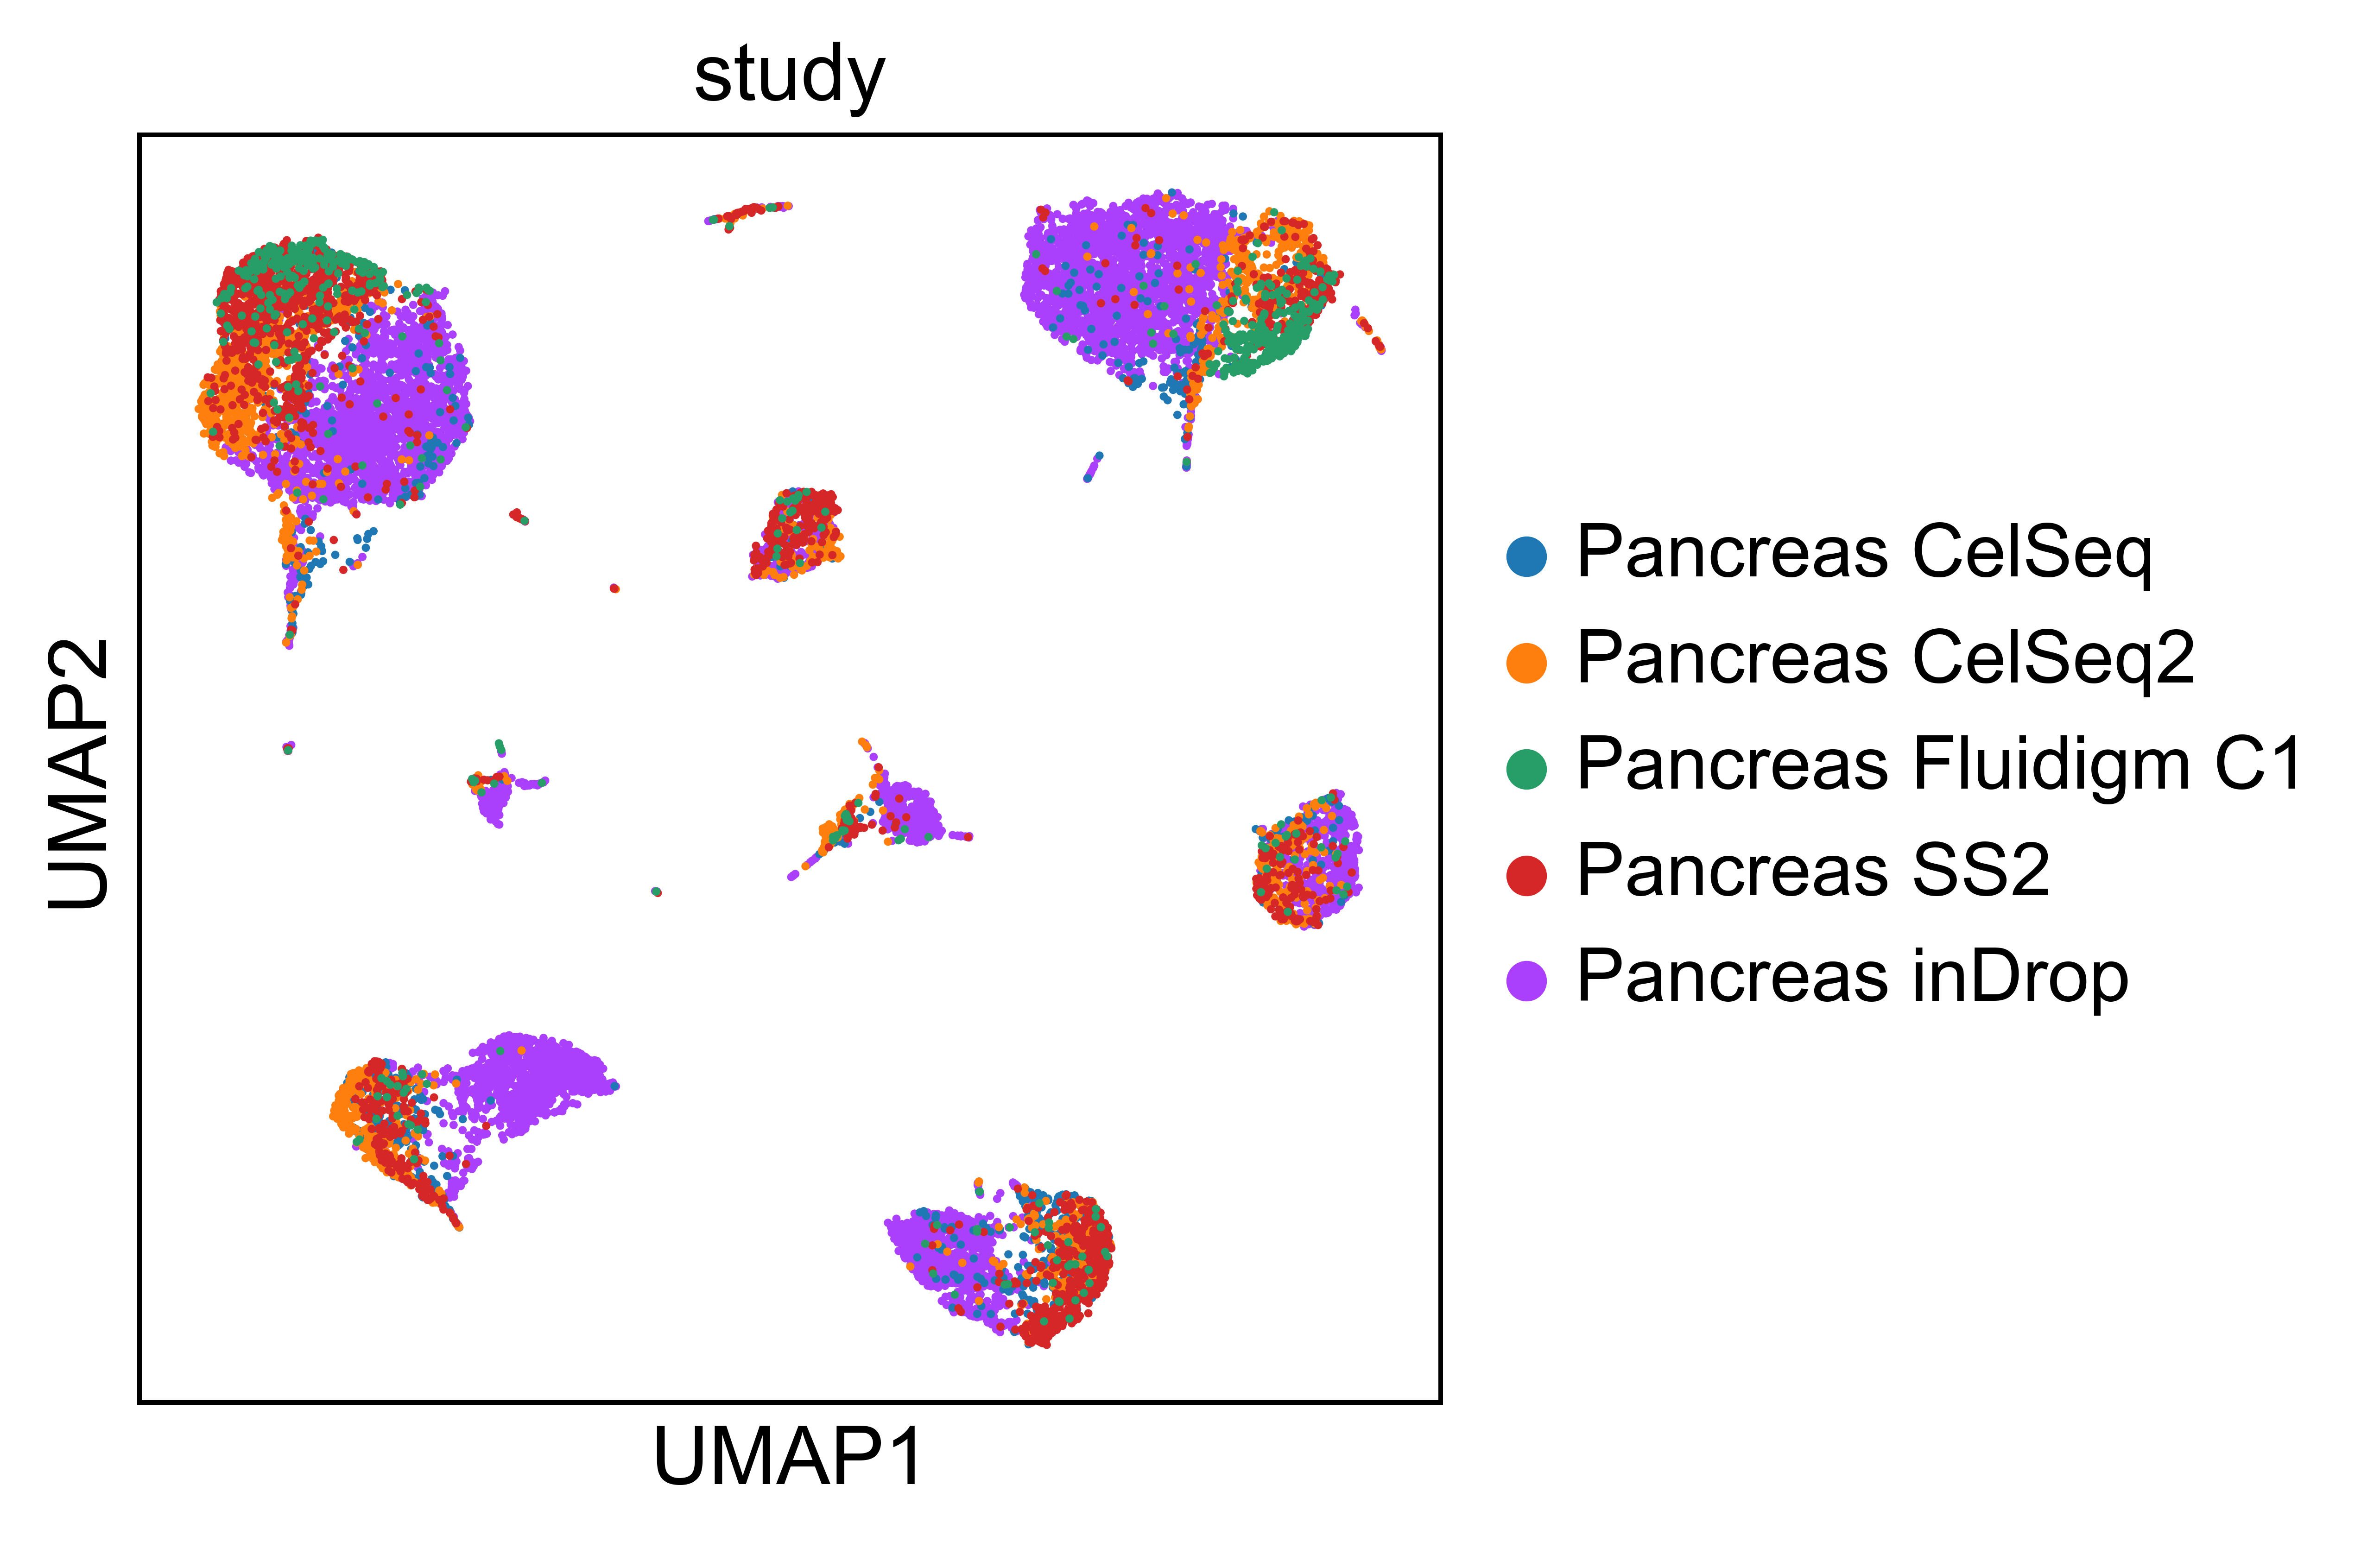

In [7]:
umaps = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2,
                  metric="cosine").fit(adata.obsm['X_scnym'])
embedding = umaps.transform(adata.obsm['X_scnym'])

embedding = pd.DataFrame(embedding)
embedding.columns=['UMAP1','UMAP2']
adata.obsm['X_umap'] = embedding.iloc[:,:2].values

sc.set_figure_params(scanpy=True, dpi=450, dpi_save=450)
sc.pl.umap(adata, color=['scNym'],save='pancreas_annotation_scNym.svg')
sc.pl.umap(adata, color=["cell_type"],save='pancreas_celltype_scNym.svg')
sc.pl.umap(adata, color=["study"],save='pancreas_batch_scNym.svg')

In [8]:
##Fig2c
subsample = adata.copy()
#sc.pp.subsample(subsample, fraction=0.1)
print(silhouette_score(subsample.obsm['X_umap'],subsample.obs['cell_type']))
print(batch_entropy_mixing_score(subsample.obsm['X_umap'],subsample.obs['study']))

0.6855604
0.38034685326471335
